<a href="https://colab.research.google.com/github/foxtrotmike/ALBRT/blob/main/GatedAttentionMIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gated Attention MIL Formulation
(Fayyaz Minhas)

## 🔍 Motivation

In **Multiple Instance Learning (MIL)**, each data point (called a "bag") contains a variable number of instances (e.g., cells, patches, spatial spots), but only the bag-level label is known.

The `GaussianMIL` model addresses this challenge by:

- Applying **learned gating functions** to each feature of each instance.
- Aggregating gated responses to form a **bag-level representation**.
- Using a **sparse linear layer** to select informative features.
- Encouraging each gate to be **informative and distributed** using an entropy-based regularization.

## 🧪 Data Simulation Summary: `simulate_mil_multifeature_realistic`

This function generates synthetic data for a Multiple Instance Learning (MIL) task. Each **bag** contains a variable number of instances (e.g., cells, patches), each with multiple features. A subset of features is designated as **informative**, meaning they influence the bag-level label through a nonlinear gating mechanism.

---

### 📦 Bag Structure

Each bag consists of:
- $T_i$ instances (random between `n_cells_range`).
- $F$ features per instance.
- A bag-level target $y_i$ generated from selected informative features.

---

### 🔍 Gating Mechanism

Each informative feature $j$ is assigned parameters:
- $a_j$: sharpness of gating function.
- $b_j$: center of gating function.

Two possible gating modes:

- **Gaussian gate**:
  $$
  g_j(x) = \exp(-a_j (x_j - b_j)^2)
  $$

- **Sigmoid gate**:
  $$
  g_j(x) = \frac{1}{1 + \exp(-a_j (x_j - b_j))}
  $$

These gates control how feature values contribute to the simulated output.

---

### 🎯 Label Generation

For each bag:
- Gates $g_j(x_{tj})$ are applied to informative features.
- The bag label $y_i$ is computed as:

  $$
  y_i = \sum_{j \in \mathcal{I}} \text{Percentile}_{q}(g_j(x_{tj})) + \varepsilon
  $$

  where:
  - $\mathcal{I}$ is the set of informative feature indices.
  - $q$ is the `driver_percentile` (e.g., 99).
  - $\varepsilon$ is Gaussian noise (`noise_std`).

---

### ⚙️ Control Parameters

| Parameter | Role |
|----------|------|
| `num_samples` | Number of bags to generate |
| `num_features` | Number of features per instance |
| `informative_idx` | Indices of features that drive the output |
| `mode` | Gating type: `'gaussian'` or `'sigmoid'` |
| `n_cells_range` | Range of instance counts per bag |
| `driver_percentile` | Percentile of gate output used in label |
| `noise_std` | Standard deviation of noise added to labels |
| `seed` | Random seed for reproducibility |

---

### ✅ Use Case

This function enables controlled experiments for MIL model development, helping evaluate:
- Feature selection behavior,
- Gating dynamics,
- Robustness to bag size and noise.



---

## 📊 Preprocessing

Given a set of instance-level input features $x_{itj}$ for instance $t$ in bag $i$ and feature $j$, we perform **z-score normalization** over the entire dataset:

$$
x_{itj}^{\text{norm}} = \frac{x_{itj} - \mu_j}{\sigma_j + \varepsilon}
$$

where $\mu_j$ and $\sigma_j$ are the mean and standard deviation of feature $j$ across all instances.

---

## 🔣 Model Representation

### 1. Gating Function

Each feature $j$ uses a Gaussian (default or sigmoid) gate centered at $b_j$ with sharpness $a_j$:

$$
g_j(x_{itj}) = \exp\left(-a_j (x_{itj}^{\text{norm}} - b_j)^2\right)
$$

- $a_j = \text{softplus}(a_j^{\text{raw}})$ ensures $a_j > 0$
- $b_j = b_j^{\min} + (b_j^{\max} - b_j^{\min}) \cdot \sigma(b_j^{\text{raw}})$ ensures $b_j \in [b_j^{\min}, b_j^{\max}]$ (should be set to cover (more than) the dynamic range of each normalized feature value.

Although we use only Gaussian gating functions of the form the model is still capable of approximating a wide range of gating behaviors, including sigmoidal or threshold-like activations. This is because:
By tuning the sharpness parameter $a_j$, the Gaussian can behave like a soft threshold, where the gate activates only near a specific value $b_j$.
When the input data spans only part of the Gaussian curve (e.g., the rising edge, peak, or falling edge), the resulting gate function can resemble:
 - a sigmoid-like curve (left or right tail),

- a step function (steep Gaussian),

- or even a flat response (very broad Gaussian).

This enables the model to flexibly learn nonlinear feature importance profiles without explicitly using other gating forms. This model can be viewed as a shallow, feature-wise Radial Basis Function (RBF) neural network, where each input feature is passed through its own learnable 1D Gaussian gate (RBF unit), followed by aggregation and linear combination.

### 2. Bag-wise Aggregation with Attention

We first compute **feature-wise gated outputs** $g_j(x_{itj})$ for each instance $t$ in bag $i$, where:

$$
g_j(x_{itj}) = \exp\left(-a_j (x_{itj}^{\text{norm}} - b_j)^2\right)
$$

Next, we compute **attention weights** over instances using either a learned attention network or uniform averaging. These are used to compute a **weighted average of gated features** for each bag:

$$
\bar{g}_{ij} = \sum_{t=1}^{T_i} \alpha_{it} \cdot g_j(x_{itj}), \quad \text{where } \sum_{t=1}^{T_i} \alpha_{it} = 1, \; \alpha_{it} \geq 0
$$

This gives a per-bag feature vector $\bar{g}_i = [\bar{g}_{i1}, \dots, \bar{g}_{iF}]$.

Let $g_{it} \in \mathbb{R}^F$ denote the **gated feature vector** for instance $t$ in bag $i$:


#### **Case 1: Learned Attention**

If an attention network is provided, a scalar score is computed for each instance using a neural network applied to the gated feature vector:

$$
s_{it} = \mathrm{AttnNet}(g_{it}) \in \mathbb{R}
$$

The attention weights are then computed using the softmax function over valid instances in bag $i$:

$$
\alpha_{it} = \frac{\exp(s_{it})}{\sum_{t'=1}^{T_i} \exp(s_{it'})}
$$

This ensures that the attention weights $\alpha_{it}$ form a probability distribution:

$$
\sum_{t=1}^{T_i} \alpha_{it} = 1 \quad \text{and} \quad \alpha_{it} \geq 0
$$

The aggregated gated output for each feature $j$ is then computed as:

$$
\bar{g}_{ij} = \sum_{t=1}^{T_i} \alpha_{it} \cdot g_j(x_{itj})
$$

---

#### **Case 2: No Attention Network (Uniform Weights)**

If no attention network is given, uniform weights are used over all valid instances:

$$
\alpha_{it} = \frac{1}{T_i}
$$

and the aggregation simplifies to a simple average over the valid instances:

$$
\bar{g}_{ij} = \frac{1}{T_i} \sum_{t=1}^{T_i} g_j(x_{itj})
$$

---

### 3. Batch-wise Normalization

The aggregated gated features are then z-normalized across the batch dimension:

$$
\tilde{g}_{ij} = \frac{\bar{g}_{ij} - \mu_j^g}{\sigma_j^g + \varepsilon}
$$

where:

- $\mu_j^g$ and $\sigma_j^g$ are the batch-wise mean and standard deviation of feature $j$ across all bags,
- $\varepsilon$ is a small constant for numerical stability.

---

### 4. Bag-level Prediction

The final prediction for bag $i$ is computed by a linear combination of normalized aggregated features:

$$
\hat{y}_i = \sum_{j=1}^F w_j \tilde{g}_{ij}
$$

where $w_j$ are the learnable weights of the final linear layer.



## 🎯 Loss Function

### 1. Correlation Loss

We aim to **maximize the Pearson correlation** between predictions and true targets:

$$
\mathcal{L}_{\text{corr}} = 1 - \text{corr}(\hat{\mathbf{y}}, \mathbf{y})
$$

### 2. Feature Sparsity (L1 Loss)

We enforce sparsity in the linear weights:

$$
\mathcal{L}_{\text{L1}} = \lambda_1 \sum_{j=1}^F |w_j|
$$

### 3. Gate Entropy Regularization

For each feature $j$, we compute the **binary entropy** of the gated outputs over all instances:

$$
H_j = -\frac{1}{N_j} \sum_{i,t} \left[ g_j(x_{itj}) \log g_j(x_{itj}) + (1 - g_j(x_{itj})) \log (1 - g_j(x_{itj})) \right]
$$

We encourage high entropy for features with high weight:

$$
\mathcal{L}_{\text{entropy}} = -\lambda_2 \sum_{j=1}^F |w_j| \cdot H_j
$$

---

## 🧮 Total Objective

The complete loss function is:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{corr}} + \mathcal{L}_{\text{L1}} + \mathcal{L}_{\text{entropy}}
$$

---

## 📈 Interpreting the Plots

### 1. **Prediction vs. Target Scatter Plot**

- Each point = one bag.
- Ideal: Points lie along the diagonal line $y = \hat{y}$.
- Spread = prediction error; correlation indicates predictive power.

---

### 2. **Per-Feature Gating Plots (Input vs. $g_j(x)$)**

- $x_j$ on X-axis, gated output $g_j(x)$ on Y-axis.
- Colored by density (hexbin): brighter = more points.
- Each plot shows:
  - **Entropy** of $g_j(x)$ values across instances.
  - **Linear weight** $w_j$: how much this feature contributes to prediction.

**Interpretation**:
- A peaked curve with **low entropy** → gate only activates for narrow input ranges.
- A smooth bell-shaped or wide gate with **high entropy** → gate activates over a broader input range.
- A high weight with high entropy → this feature is informative and consistently used.

---

### 3. **Parameter Summary Table**

Shows:
- $a_j$: Gate sharpness (higher = narrower peak).
- $b_j$: Gate center (on normalized scale).
- $w_j$: Linear weight (importance of this feature).

Use this to understand:
- **What feature regions are being gated** (via $b_j$),
- **How selective the gates are** (via $a_j$),
- **Which features are most predictive** (via $w_j$).

## ✅ Summary

This model:
- Learns instance-level gating via differentiable functions.
- Aggregates gated signals per feature into a global prediction.
- Applies regularization to promote sparse and informative gating.
- Is highly interpretable, as $a_j$, $b_j$, $w_j$, and $H_j$ offer semantic meaning.

It is especially suitable for **weakly-supervised learning**, **instance selection**, and **feature-wise interpretability** in high-dimensional settings.



--- Training  ---
Epoch 0 | Corr Loss: 1.1352 | L1: 0.1283 | Entropy: -0.0017
Epoch 20 | Corr Loss: 0.9019 | L1: 0.0927 | Entropy: -0.0007
Epoch 40 | Corr Loss: 0.4184 | L1: 0.0466 | Entropy: -0.0008
Epoch 60 | Corr Loss: 0.0480 | L1: 0.0380 | Entropy: -0.0013
Epoch 80 | Corr Loss: 0.0411 | L1: 0.0357 | Entropy: -0.0014
Epoch 100 | Corr Loss: 0.0402 | L1: 0.0332 | Entropy: -0.0013
Epoch 120 | Corr Loss: 0.0395 | L1: 0.0308 | Entropy: -0.0012
Epoch 140 | Corr Loss: 0.0386 | L1: 0.0279 | Entropy: -0.0011
Epoch 160 | Corr Loss: 0.0377 | L1: 0.0252 | Entropy: -0.0010
Epoch 180 | Corr Loss: 0.0369 | L1: 0.0219 | Entropy: -0.0009

Final Pearson r - : 0.9641


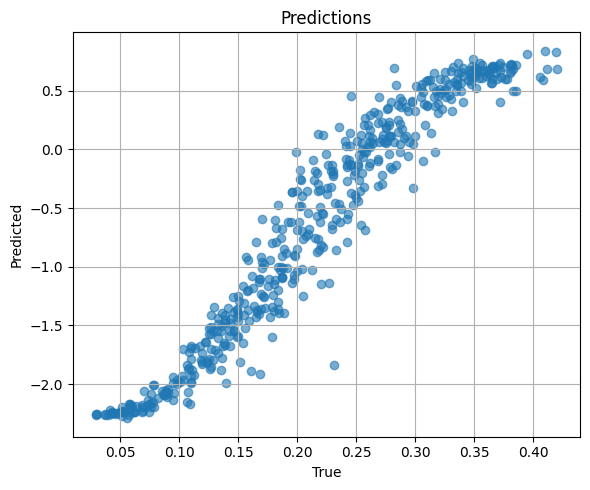


=== MIL Parameters with Entropy ===
   Feature  a (sharpness)  b (center)  Linear Weight  Gated Entropy
0        0          1.276       0.193          1.000          0.392
1        1          0.957       2.628          0.010          0.106
2        2          0.094       1.826         -0.009          0.491
3        3          0.805      -3.672          0.002          0.026
4        4          0.769       3.481          0.003          0.041


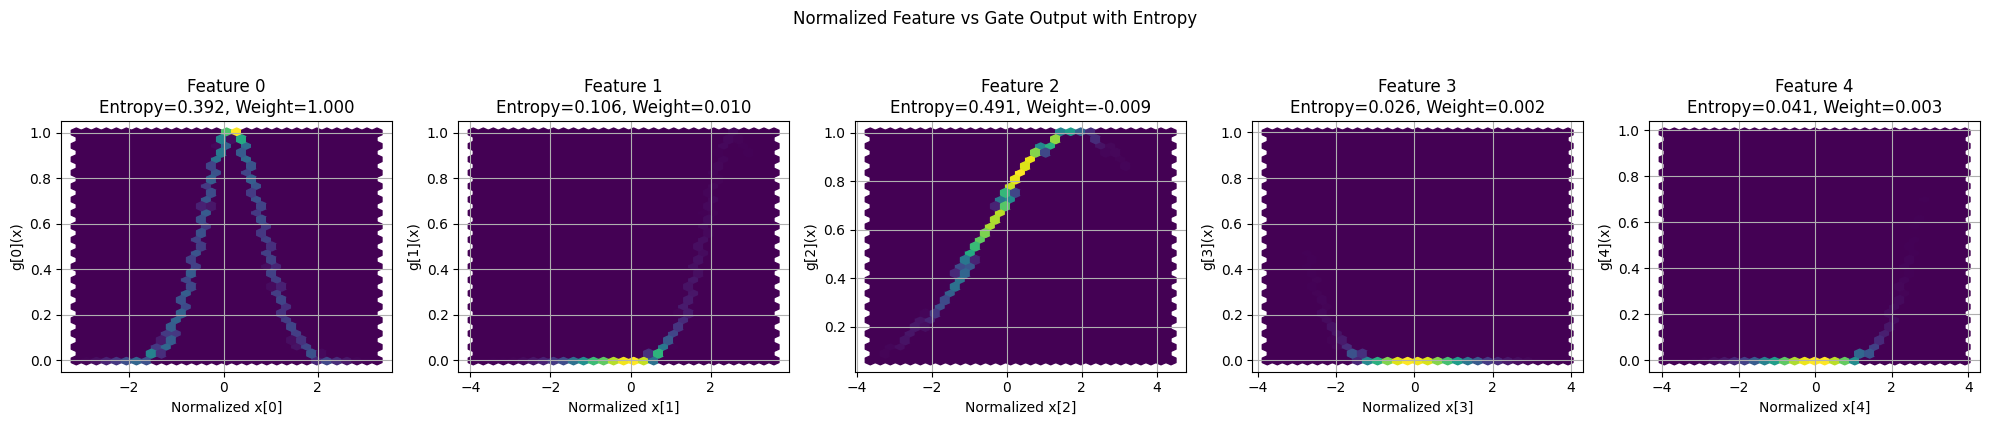

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

# === Loss ===
def negative_pearson_loss(pred, target):
    pred = pred - pred.mean()
    target = target - target.mean()
    pred = pred / (pred.norm() + 1e-6)
    target = target / (target.norm() + 1e-6)
    return 1.0 - torch.sum(pred * target)

# === GaussianMIL Model ===
class GatedAttentionMIL(nn.Module):
    def __init__(self, num_features, b_min, b_max, attention_net=None, gate = 'gaussian'):
        super().__init__()
        self.num_features = num_features
        self.gate = gate
        self.register_buffer('b_min', torch.tensor(b_min, dtype=torch.float32))
        self.register_buffer('b_max', torch.tensor(b_max, dtype=torch.float32))
        self.a_raw = nn.Parameter(torch.randn(num_features))
        self.b_raw = nn.Parameter(torch.randn(num_features))
        self.linear = nn.Linear(num_features, 1)
        self.batchnorm = nn.BatchNorm1d(num_features, affine=False)

        # Optional external attention module
        self.attention_net = attention_net

    def forward(self, x, mask):
        a = F.softplus(self.a_raw)
        b = self.b_min + (self.b_max - self.b_min) * torch.sigmoid(self.b_raw)

        # Gaussian gating
        x_ = x.unsqueeze(2)  # [B, T, F, 1]
        a_ = a.unsqueeze(0).unsqueeze(0)
        b_ = b.unsqueeze(0).unsqueeze(0)
        if self.gate == 'gaussian':
            g = torch.exp(-a_ * (x_ - b_) ** 2).squeeze(2)  # [B, T, F]
        elif self.gate == 'sigmoid':
            g = torch.sigmoid(a_ * (x_ - b_)).squeeze(2)  # [B, T, F]
        else:
            raise ValueError(f"Unknown gate type: {self.gate}")
        g = g * mask.unsqueeze(-1)

        # Attention weights (either external or uniform)
        if self.attention_net is not None:
            attn_scores = self.attention_net(g).squeeze(-1)  # [B, T]
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))
            attn_weights = torch.softmax(attn_scores, dim=1)  # [B, T]
        else:
            attn_weights = mask / (mask.sum(dim=1, keepdim=True) + 1e-6)  # [B, T]

        # Apply attention to gated outputs
        g_weighted = torch.einsum('bt,btf->bf', attn_weights, g)

        # Normalize across batch using BatchNorm
        agg_z =  self.batchnorm(g_weighted)

        return self.linear(agg_z).squeeze(1), a, b, g, attn_weights


# === Data Generator ===
def simulate_mil_multifeature_realistic(num_samples=100, num_features=5, informative_idx=[0, 2],
                                        mode='sigmoid', n_cells_range=(10, 100),
                                        driver_percentile=50, noise_std=0.0, seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    X_data, y_vals = [], []
    a_vals = np.random.uniform(1.5, 5.0, len(informative_idx))
    b_vals = np.random.uniform(-2, 2, len(informative_idx))

    def gaussian_gate(x, a, b):
        return np.exp(-a * (x - b) ** 2)

    def sigmoid_gate(x, a, b):
        return 1 / (1 + np.exp(-a * (x - b)))

    def inverse_gaussian_peak(z, a, b, n_cells, jitter=0.1):
        z = np.clip(z, 1e-6, 1.0)
        r = np.sqrt(-np.log(z) / a)
        signs = np.random.choice([-1, 1], size=n_cells)
        x = b + signs * r
        x += np.random.randn(n_cells) * jitter
        return x

    def inverse_sigmoid_peak(z, a, b, n_cells, jitter=0.1):
        z = np.clip(z, 1e-6, 1.0 - 1e-6)
        logit_z = np.log(z / (1 - z)) / a
        signs = np.random.choice([-1, 1], size=n_cells)
        x = b + signs * np.abs(logit_z)
        x += np.random.randn(n_cells) * jitter
        return x

    for _ in range(num_samples):
        n_cells = np.random.randint(*n_cells_range)
        z_j = np.random.uniform(0.2, 0.95)
        x_full = np.random.normal(0, 1, (n_cells, num_features))

        for i, idx in enumerate(informative_idx):
            a, b = a_vals[i], b_vals[i]
            x_inf = inverse_gaussian_peak(z_j, a, b, n_cells) if mode == 'gaussian' \
                else inverse_sigmoid_peak(z_j, a, b, n_cells)
            x_full[:, idx] = x_inf

        z_sum = 0
        for i, idx in enumerate(informative_idx):
            a, b = a_vals[i], b_vals[i]
            z_vals = gaussian_gate(x_full[:, idx], a, b) if mode == 'gaussian' \
                else sigmoid_gate(x_full[:, idx], a, b)
            z_sum += np.percentile(z_vals, driver_percentile)

        y = z_sum + np.random.normal(0, noise_std)
        X_data.append(torch.tensor(x_full, dtype=torch.float32))
        y_vals.append(y)

    return X_data, torch.tensor(y_vals, dtype=torch.float32), {
        "a_vals": a_vals, "b_vals": b_vals,
        "informative": informative_idx, "mode": mode
    }

# === Prepare Batch ===
def prepare_batch(data_list):
    padded = pad_sequence(data_list, batch_first=True)
    mask = torch.zeros(padded.shape[:2])
    for i, x in enumerate(data_list):
        mask[i, :x.shape[0]] = 1.0
    return padded, mask

# === Training ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_list, targets, params = simulate_mil_multifeature_realistic(
    num_samples=500,
    num_features=5,
    informative_idx=[0],
    driver_percentile=0.95,
    mode='sigmoid'
)

x_all = torch.cat(data_list, dim=0)
feat_mean = x_all.mean(dim=0)
feat_std = x_all.std(dim=0) + 1e-6
x_all_norm = (x_all - feat_mean) / feat_std
b_min = torch.quantile(x_all_norm, 0.0, dim=0).numpy()-3
b_max = torch.quantile(x_all_norm, 1.0, dim=0).numpy()+3
data_list_norm = [(x - feat_mean) / feat_std for x in data_list]
x_batch, mask = prepare_batch(data_list_norm)
x_batch, mask, targets = x_batch.to(device), mask.to(device), targets.to(device)

learned_attn = nn.Sequential(
    nn.Linear(x_batch.shape[2], 1),
    #nn.Tanh(),
    #nn.Linear(16, 1)
)
#learned_attn = None #if you want no instance level attention
model = GatedAttentionMIL(num_features=x_batch.shape[2], b_min=b_min, b_max=b_max, attention_net = learned_attn, gate = 'gaussian').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


l1_lambda = 10e-2
entropy_lambda = 1e-2

print("\n--- Training  ---")
for epoch in range(200):
    model.train()
    pred, a, b, g, attn_weights = model(x_batch, mask)
    corr_loss = negative_pearson_loss(pred, targets)
    l1_loss = l1_lambda * model.linear.weight.abs().sum()

    # === Entropy loss computation (fixed) ===
    g_masked = g * mask.unsqueeze(-1)  # shape: [B, T, F]
    g_flat = g_masked[mask.bool()]     # shape: [num_valid, F]
    g_clamped = torch.clamp(g_flat, 1e-6, 1 - 1e-6)
    entropy = -g_clamped * torch.log(g_clamped) - (1 - g_clamped) * torch.log(1 - g_clamped)
    entropy_mean = entropy.mean(dim=0)  # shape: [F]
    w = model.linear.weight.squeeze(0)
    entropy_loss = -entropy_lambda * torch.sum(torch.abs(w) * entropy_mean)

    # === Total loss
    loss = corr_loss + l1_loss + entropy_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Corr Loss: {corr_loss.item():.4f} | L1: {l1_loss.item():.4f} | Entropy: {entropy_loss.item():.4f}")

with torch.no_grad():
    # Normalize final weights
    w = model.linear.weight
    model.linear.weight.div_(w.norm(p=2) + 1e-6)

model.eval()
with torch.no_grad():
    pred, a, b, g, attn_weights = model(x_batch, mask)
    pred = pred.cpu()
    targets_cpu = targets.cpu()
    r = pearsonr(pred.numpy(), targets_cpu.numpy())[0]
    print(f"\nFinal Pearson r - : {r:.4f}")

# === Plot: Predictions vs Targets ===
plt.figure(figsize=(6, 5))
plt.scatter(targets_cpu, pred, alpha=0.6)
plt.title("Predictions")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Print Parameters ===
with torch.no_grad():
    a_np = a.cpu().numpy()
    b_np = b.cpu().numpy()
    weights = model.linear.weight.cpu().numpy().flatten()
# === Compute entropy of gated feature values ===
x_flat = torch.cat(data_list_norm, dim=0).cpu().numpy()
g_flat = g[mask.bool()].cpu().numpy()
g_clamped = np.clip(g_flat, 1e-6, 1 - 1e-6)
entropy_vals = (-g_clamped * np.log(g_clamped) - (1 - g_clamped) * np.log(1 - g_clamped)).mean(axis=0)

# === Construct DataFrame with model parameters and entropy ===
df = pd.DataFrame({
    "Feature": np.arange(model.num_features),
    "a (sharpness)": a_np,
    "b (center)": b_np,
    "Linear Weight": weights,
    "Gated Entropy": entropy_vals
})

print("\n=== MIL Parameters with Entropy ===")
print(df.round(3))

# === Plot: Input vs Gate Output (with entropy in titles) ===
fig, axes = plt.subplots(1, model.num_features, figsize=(4 * model.num_features, 4))
if model.num_features == 1:
    axes = [axes]

for i in range(model.num_features):
    axes[i].hexbin(x_flat[:, i], g_flat[:, i], gridsize=30, cmap='viridis')
    axes[i].set_xlabel(f'Normalized x[{i}]')
    axes[i].set_ylabel(f'g[{i}](x)')
    axes[i].set_title(f'Feature {i}\nEntropy={entropy_vals[i]:.3f}, Weight={weights[i]:.3f}')
    axes[i].grid(True)

plt.suptitle("Normalized Feature vs Gate Output with Entropy", y=1.05)
plt.tight_layout()
plt.show()



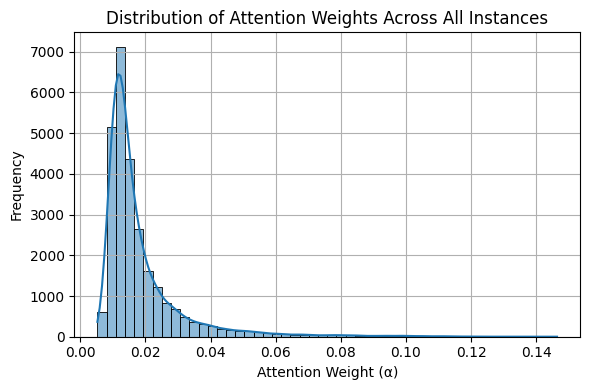

In [2]:
with torch.no_grad():
    model.eval()
    _, _, _, g, alpha = model(x_batch, mask)  # update forward() to return alpha

    alpha_masked = alpha * mask  # shape: [B, T]
    alpha_flat = alpha_masked[mask.bool()].cpu().numpy()  # shape: [num_instances]
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.histplot(alpha_flat, bins=50, kde=True)
plt.title("Distribution of Attention Weights Across All Instances")
plt.xlabel("Attention Weight (α)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()
